In [1]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [13]:

from utils import *

In [3]:
ge_df = pd.read_csv("datasets/merged-combat15.csv", index_col="patient_ID")
state_df = pd.read_csv("datasets/state_and_outcome.csv", index_col="patient_ID")
bc_clinical_df = pd.read_csv("datasets/bcClinicalTable.csv", index_col="patient_ID")
tamoxifen_studies = ["GSE12093",  "GSE1379", "GSE16391", "GSE17705", "GSE6577",  "GSE9893"]
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE6577",  "GSE9893"]

In [4]:
state_sub_df = state_df[state_df["series_id"].isin(tamoxifen_studies_v2)]
state_sub_df

,series_id,gpl,channel_count,RFS,DFS,pCR,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome,posOutcome2
patient_ID,,,,,,,,,,,,,,,
249296,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,NaN,T1,LumA,k2,0,0.0
249524,GSE9893,GPL5049,1,1.0,NaN,NaN,1.0,NaN,1.0,1.0,T1,LumB,k2,1,1.0
249527,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,1.0,T2,LumA,k1,0,0.0
249529,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,1.0,T1,LumA,k2,0,0.0
249530,GSE9893,GPL5049,1,1.0,NaN,NaN,1.0,NaN,1.0,1.0,T1,LumA,k1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k3,1,1.0
305261,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k5,1,1.0
305262,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k4,1,1.0


In [5]:
cols = ["gpl", "ER", "HER2", "PR", "node", "tumor", "pam_coincide", "p5"]

for col in cols:
    print("{0}: {1}".format(col, state_sub_df[col].unique()))

gpl: ['GPL5049' 'GPL1223' 'GPL96']
ER: [1. 0.]
HER2: [nan  1.  0.]
PR: [ 0.  1. nan]
node: [nan  1.  0.]
tumor: ['T1' 'T2' 'T4' 'T3' nan]
pam_coincide: ['LumA' 'LumB' 'Her2' 'Basal' 'Normal']
p5: ['k2' 'k1' 'k3' 'k5' 'k4']


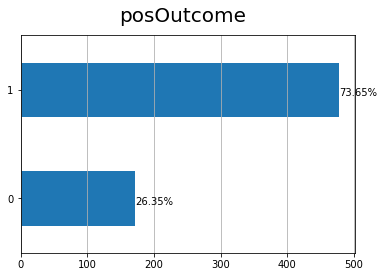

In [6]:
plot_percentages(state_sub_df)

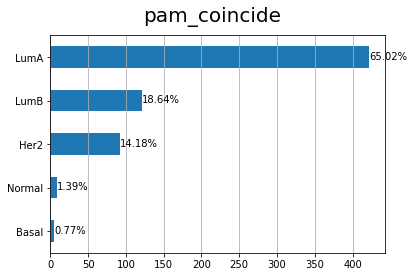

In [7]:
plot_percentages(state_sub_df, "pam_coincide")

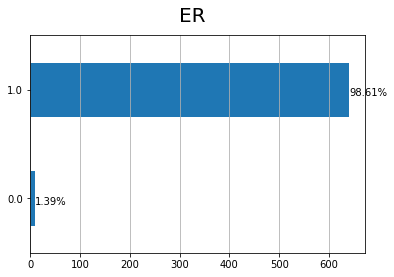

In [8]:
plot_percentages(state_sub_df, "ER")

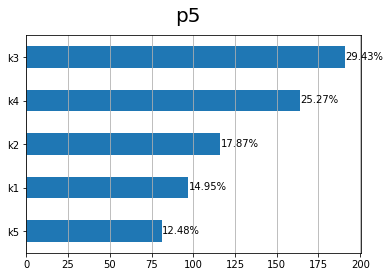

In [9]:
plot_percentages(state_sub_df, "p5")


In [10]:
ge_sub_df = ge_df.loc[state_sub_df.index,:]
ge_sub_outcome_df = pd.merge(state_sub_df["posOutcome"], ge_sub_df, left_index=True, right_index=True)
X_ge_train, X_ge_test, y_ge_train, y_ge_test = get_train_test_set(ge_sub_outcome_df, "/var/www/datasets/tamox_train_set.txt", "/var/www/datasets/tamox_test_set.txt")

In [11]:
ge_sub_outcome_df.to_csv("datasets/ge_outcome_tamoxifen.csv", index=False)

In [12]:
from pymrmre import mrmr
solutions = mrmr.mrmr_ensemble(features=X_ge_train, targets=y_ge_train.to_frame(), solution_length=100, solution_count=1)
feats_100 = solutions[0][0]

In [17]:
params_ge_sub_acc, clf_ge_sub_acc, cv_scores_ge_sub_acc, test_scores_ge_sub_acc = evaluate_ge((X_ge_train, X_ge_test, y_ge_train, y_ge_test), feats=feats_100, split=False, scale_weight=False, rand_scoring="balanced_accuracy")
print(params_ge_sub_acc)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:48:41] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:48:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 2.98 seconds.
Best Score: 69.991%
{'subsample': 0.6, 'n_estimators': 120, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 1.5, 'colsample_bytree': 0.8}
[12:48:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.7s finished


In [20]:
params_ge_sub_auc, clf_ge_sub_auc, cv_scores_ge_sub_auc, test_scores_ge_sub_auc = evaluate_ge((X_ge_train, X_ge_test, y_ge_train, y_ge_test), feats=feats_100, split=False, scale_weight=False)
print(params_ge_sub_auc)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[13:11:19] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:11:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 3.05 seconds.
Best Score: 83.177%
{'subsample': 0.6, 'n_estimators': 120, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 1.5, 'colsample_bytree': 0.8}
[13:11:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was ch

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  94 out of 125 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.7s finished


In [21]:
params_ge_sub_ap, clf_ge_sub_ap, cv_scores_ge_sub_ap, test_scores_ge_sub_ap = evaluate_ge((X_ge_train, X_ge_test, y_ge_train, y_ge_test), feats=feats_100, split=False, scale_weight=False, rand_scoring=average_precision_0)
print(params_ge_sub_auc)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[13:19:53] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:19:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 4.68 seconds.
Best Score: 23.565%
{'subsample': 0.6, 'n_estimators': 20, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.6}
[13:19:55] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.6s finished


In [ ]:
state_sub_df[~state_sub_df["DFS"].isnull()]

In [ ]:
state_sub_df[~state_sub_df["RFS"].isnull()]

In [ ]:
state_sub_df[~state_sub_df["pCR"].isnull()]

In [ ]:
fts_100_disc_df = pd.read_csv("datasets/mrmr_top100_treat_disc.tsv", sep="\t")
fts_100_disc_df.columns = ["Order", "Feat_Index", "Name", "Score"]
fts_100_disc_df["Name"] = fts_100_disc_df["Name"].str.strip()
feats_100_disc = fts_100_disc_df["Name"].to_list()

In [ ]:
overlap = [x for x in feats_100_disc if x in feats_100]
print("Num overlap: " + str(len(overlap)))
overlap

In [ ]:
params_ge_sub_disc, clf_ge_sub_disc, cv_scores_ge_sub_disc, test_scores_ge_sub_disc = evaluate_ge(X_sub_ge_train, y_sub_ge_train,
         X_sub_ge_test, y_sub_ge_test, feats=feats_100_disc)
print(params_ge_sub_disc)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_disc.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_disc.mean()))

In [ ]:
fts_100_MID_df = pd.read_csv("datasets/mrmr_top100_treat_MID.tsv", sep="\t")
fts_100_MID_df.columns = ["Order", "Feat_Index", "Name", "Score"]
fts_100_MID_df["Name"] = fts_100_MID_df["Name"].str.strip()
feats_100_MID = fts_100_MID_df["Name"].to_list()

In [ ]:
overlap_2 = [x for x in feats_100_MID if x in feats_100]
print("Num overlap: " + str(len(overlap_2)))
overlap_2

In [ ]:
params_ge_sub_MID, clf_ge_sub_MID, cv_scores_ge_sub_MID, test_scores_ge_sub_MID = evaluate_ge(X_sub_ge_train, y_sub_ge_train, X_sub_ge_test, y_sub_ge_test, feats=feats_100_MID)
print(params_ge_sub_MID)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_MID.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_MID.mean()))

In [ ]:
feats_50 = feats_100[:50]

In [ ]:
params_ge_sub_50, clf_ge_sub_50, cv_scores_ge_sub_50, test_scores_ge_sub_50 = evaluate_ge(X_sub_ge_train, y_sub_ge_train,  X_sub_ge_test, y_sub_ge_test, feats=feats_50)
print(params_ge_sub_50)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_50.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_50.mean()))

In [ ]:
print_score_comparison(test_scores_ge_sub_50, test_scores_ge_sub, header_1="feats 50", header_2="feats 100")

In [ ]:
print_score_comparison(test_scores_ge_sub, test_scores_ge_sub_disc, header_1="feats 100", header_2="feats 100 Disc")

In [ ]:
state_sub_df.loc[state_sub_df["series_id"] == "GSE16391"]

In [22]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE6577",  "GSE9893"]

In [23]:
state_sub_v2_df = state_df[state_df["series_id"].isin(tamoxifen_studies_v2)]
radio_therapy_df = bc_clinical_df["radiotherapyClass"]
state_sub_v2_df = pd.merge(state_sub_v2_df, radio_therapy_df, left_index=True, right_index=True)
state_sub_v2_df

,series_id,gpl,channel_count,RFS,DFS,pCR,ER,HER2,PR,node,tumor,pam_coincide,p5,posOutcome,posOutcome2,radiotherapyClass
patient_ID,,,,,,,,,,,,,,,,
249296,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,NaN,T1,LumA,k2,0,0.0,1.0
249524,GSE9893,GPL5049,1,1.0,NaN,NaN,1.0,NaN,1.0,1.0,T1,LumB,k2,1,1.0,1.0
249527,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,1.0,T2,LumA,k1,0,0.0,1.0
249529,GSE9893,GPL5049,1,0.0,NaN,NaN,1.0,NaN,0.0,1.0,T1,LumA,k2,0,0.0,1.0
249530,GSE9893,GPL5049,1,1.0,NaN,NaN,1.0,NaN,1.0,1.0,T1,LumA,k1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k3,1,1.0,0.0
305261,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k5,1,1.0,0.0
305262,GSE12093,GPL96,1,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,LumA,k4,1,1.0,0.0


In [26]:
state_sub_v2_df = state_sub_v2_df.drop(["channel_count", "RFS", "DFS", "pCR", "posOutcome2"], axis=1)
state_sub_v2_df.isnull().sum()

series_id              0
gpl                    0
ER                     0
HER2                 592
PR                   434
node                 159
tumor                434
pam_coincide           0
p5                     0
posOutcome             0
radiotherapyClass      7
dtype: int64

In [ ]:
# state_sub_v2_df = state_sub_v2_df[state_sub_v2_df["radiotherapyClass"].notna()]

In [ ]:
ge_sub_v2_df = ge_df.loc[state_sub_v2_df.index,:]
ge_sub_outcome_v2_df = pd.merge(state_sub_v2_df["posOutcome"], ge_sub_v2_df, left_index=True, right_index=True)
ge_sub_outcome_v2_df

In [ ]:
ge_sub_outcome_v2_df.to_csv("datasets/ge_outcome_tamoxifen_v2.csv", index=False)

In [ ]:
fts_100_v2_df = pd.read_csv("datasets/mrmr_top100_treat_v2.tsv", sep="\t")
fts_100_v2_df.columns = ["Order", "Feat_Index", "Name", "Score"]
fts_100_v2_df["Name"] = fts_100_v2_df["Name"].str.strip()
feats_100_v2 = fts_100_v2_df["Name"].to_list()

In [ ]:
overlap_3 = [x for x in feats_100_v2 if x in feats_100]
print("Num overlap: " + str(len(overlap_3)))
overlap_3

In [ ]:
X_sub_ge_v2, y_sub_ge_v2 = ge_sub_outcome_v2_df.drop(["posOutcome"], axis=1), ge_sub_outcome_v2_df["posOutcome"]

X_sub_ge_v2_train, X_sub_ge_v2_test, y_sub_ge_v2_train, y_sub_ge_v2_test = train_test_split(X_sub_ge_v2, y_sub_ge_v2, test_size=0.3, random_state=seed)

In [ ]:
params_ge_sub_v2, clf_ge_sub_v2, cv_scores_ge_sub_v2, test_scores_ge_sub_v2 = evaluate_ge(X_sub_ge_v2_train, y_sub_ge_v2_train, X_sub_ge_v2_test, y_sub_ge_v2_test,
                                                                                feats=feats_100_v2)
print(params_ge_sub_v2)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v2.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v2.mean()))

In [ ]:
print_score_comparison(cv_scores_ge_sub, cv_scores_ge_sub_v2, header_1="With GSE16391",
     header_2="W/o GSE16391", target_feature="posOutcome - validation set")

In [ ]:
print_score_comparison(test_scores_ge_sub, test_scores_ge_sub_v2, header_1="With GSE16391",
                     header_2="W/o GSE16391", target_feature="posOutcome - test set")

In [ ]:
plot_percentages(state_sub_v2_df, "radiotherapyClass")

In [ ]:
with open("datasets/mrmr_ft100_treat_v2.txt", "w") as fp:
    for ft in feats_100:
        fp.write("%s\n" % ft)

In [ ]:
state_sub_v2_df.isnull().sum()


In [ ]:
##Training on features that have no or very few missing values
state_sub_v3_df = state_sub_v2_df[~state_sub_v2_df["radiotherapyClass"].isnull()]
state_sub_v3_df = state_sub_v3_df.drop(["channel_count", "RFS", "DFS", "pCR", "HER2", "node", "PR", "tumor", "posOutcome2"], axis=1)
state_sub_v3_df.isnull().sum()


In [ ]:
state_sub_v3_df = label_encode(state_sub_v3_df)
state_sub_v3_df = state_sub_v3_df.astype(np.int64)
state_sub_v3_df = one_hot_encode(state_sub_v3_df, ["series_id", "gpl", "pam_coincide", "radiotherapyClass", "p5"])

In [ ]:
ge_sub_v3_df = ge_df.loc[state_sub_v3_df.index,:]
ge_sub_outcome_v3_df = pd.merge(state_sub_v3_df, ge_sub_v3_df, left_index=True, right_index=True)
ge_sub_outcome_v3_df

In [ ]:
X_sub_ge_v3, y_sub_ge_v3 = ge_sub_outcome_v3_df.drop(["posOutcome"], axis=1), ge_sub_outcome_v3_df["posOutcome"]

X_sub_ge_v3_train, X_sub_ge_v3_test, y_sub_ge_v3_train, y_sub_ge_v3_test = train_test_split(X_sub_ge_v3, y_sub_ge_v3, test_size=0.3, random_state=seed)

In [ ]:
outcome_cols = state_sub_v3_df.drop(["posOutcome"], axis=1).columns.to_list()
print(outcome_cols)
params_ge_sub_v3, clf_ge_sub_v3, cv_scores_ge_sub_v3, test_scores_ge_sub_v3 = evaluate_ge(X_sub_ge_v3_train, y_sub_ge_v3_train, X_sub_ge_v3_test, y_sub_ge_v3_test, feats=feats_100_v2, outcome_cols=outcome_cols)
print(params_ge_sub_v3)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v3.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v3.mean()))

In [ ]:
print_score_comparison(cv_scores_ge_sub_v2, cv_scores_ge_sub_v3, header_1="W/o State",
   header_2="With State", title="Validation Score")

In [ ]:
print_score_comparison(cv_scores_ge_sub_v2, cv_scores_ge_sub_v3, header_1="W/o State",
                    header_2="With State", title="Test Score")

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
X_sub_ge_v3_test_sel = X_sub_ge_v3_test[outcome_cols + feats_100_v2]
disp = plot_precision_recall_curve(clf_ge_sub_v3, X_sub_ge_v3_test_sel, y_sub_ge_v3_test)
disp.ax_.set_title("Precision_Recall Curve")

In [ ]:
##Feeding Xgboost NA values so it can figure of the imputation while
#training
state_sub_v4_df = state_sub_v2_df[~state_sub_v2_df["radiotherapyClass"].isnull()]
state_sub_v4_df = state_sub_v4_df.drop(["channel_count", "RFS", "DFS", "pCR",
                                        "posOutcome2"], axis=1)
state_sub_v4_df = label_encode(state_sub_v4_df)

In [ ]:
state_sub_v4_df = one_hot_encode(state_sub_v4_df, ["series_id", "gpl", "pam_coincide", "radiotherapyClass", "p5"])
state_sub_v4_df = state_sub_v4_df.astype(np.float64)
state_sub_v4_df

In [ ]:
ge_sub_v4_df = ge_df.loc[state_sub_v4_df.index, :]
ge_sub_outcome_v4_df = pd.merge(state_sub_v4_df, ge_sub_v4_df, left_index=True, right_index=True)
ge_sub_outcome_v4_df

In [ ]:
X_sub_ge_v4, y_sub_ge_v4 = ge_sub_outcome_v4_df.drop(["posOutcome"], axis=1), ge_sub_outcome_v4_df["posOutcome"]

X_sub_ge_v4_train, X_sub_ge_v4_test, y_sub_ge_v4_train, y_sub_ge_v4_test = train_test_split(X_sub_ge_v4, y_sub_ge_v4, test_size=0.3, random_state=seed)

In [ ]:
outcome_cols = state_sub_v4_df.drop(["posOutcome"], axis=1).columns.to_list()
params_ge_sub_v4, clf_ge_sub_v4, cv_scores_ge_sub_v4, test_scores_ge_sub_v4 = evaluate_ge(X_sub_ge_v4_train, y_sub_ge_v4_train, X_sub_ge_v4_test, y_sub_ge_v4_test, feats=feats_100_v2, outcome_cols=outcome_cols)
print(params_ge_sub_v4)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v4.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v4.mean()))

In [ ]:
print_score_comparison(cv_scores_ge_sub_v3, cv_scores_ge_sub_v4, header_1="Non-Null w/o Weight",
                    header_2="Null w/o Weight", title="Validation set")

In [ ]:
print_score_comparison(test_scores_ge_sub_v3, test_scores_ge_sub_v4, header_1="Non-Null w/o Weight",
                    header_2="Null w/o Weight", title="Test set")

In [ ]:
#Set scale_pos_weight as the dataset is imbalanced , see - https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
class_1_sum = state_sub_v4_df[state_sub_v4_df["posOutcome"] == 1]["posOutcome"].count()
class_0_sum = state_sub_v4_df[state_sub_v4_df["posOutcome"] == 0]["posOutcome"].count()
scale_weight = class_1_sum/class_0_sum
print(scale_weight)

In [ ]:
outcome_cols = state_sub_v4_df.drop(["posOutcome"], axis=1).columns.to_list()
params_ge_sub_v5, clf_ge_sub_v5, cv_scores_ge_sub_v5, test_scores_ge_sub_v5 = evaluate_ge(X_sub_ge_v4_train, y_sub_ge_v4_train, X_sub_ge_v4_test, y_sub_ge_v4_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                        scale_weight=scale_weight)
print(params_ge_sub_v5)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v5.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v5.mean()))

In [ ]:
print_score_comparison(cv_scores_ge_sub_v4, cv_scores_ge_sub_v5, header_1="W/o Weight", header_2="With Weight",
                       title="Null Validation set")

In [ ]:
print_score_comparison(test_scores_ge_sub_v4, test_scores_ge_sub_v5, header_1="W/o Weight", header_2="With Weight",
                       title="Null Test set")

In [ ]:
scale_weight_2 = class_0_sum/class_1_sum
params_ge_sub_v6, clf_ge_sub_v6, cv_scores_ge_sub_v6, test_scores_ge_sub_v6 = evaluate_ge(X_sub_ge_v4_train, y_sub_ge_v4_train, X_sub_ge_v4_test, y_sub_ge_v4_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                        scale_weight=scale_weight_2)
print(params_ge_sub_v6)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v6.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v6.mean()))

In [ ]:
print_score_comparison(test_scores_ge_sub_v5, test_scores_ge_sub_v6, header_1="Weight 1", header_2="Weight 2",
                       title="Test set")

In [ ]:
print_score_comparison(test_scores_ge_sub_v4, test_scores_ge_sub_v6, header_1="W/o Weight", header_2="Weight 2",
                       title="Test set")

In [ ]:
ge_sub_outcome_v3_df

In [ ]:
ge_sub_outcome_v3_df.to_csv("datasets/ge_state_outcome_tamoxifen_v3.csv")
ge_sub_outcome_v4_df.to_csv("datasets/ge_state_outcome_tamoxifen_v4.csv")

In [ ]:
#Stratification with dataset containing Null values with scale_pos_weight
X_sub_ge_v7, y_sub_ge_v7 = ge_sub_outcome_v4_df.drop(["posOutcome"], axis=1), ge_sub_outcome_v4_df["posOutcome"]

X_sub_ge_v7_train, X_sub_ge_v7_test, y_sub_ge_v7_train, y_sub_ge_v7_test = train_test_split(X_sub_ge_v7, y_sub_ge_v7, test_size=0.3, random_state=seed, stratify=y_sub_ge_v7)

In [ ]:
print(outcome_cols)
params_ge_sub_v7, clf_ge_sub_v7, cv_scores_ge_sub_v7, test_scores_ge_sub_v7 = evaluate_ge(X_sub_ge_v7_train, y_sub_ge_v7_train, X_sub_ge_v7_test, y_sub_ge_v7_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                                                scale_weight=scale_weight)
print(params_ge_sub_v7)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v7.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v7.mean()))

In [ ]:
print_score_comparison(test_scores_ge_sub_v5, test_scores_ge_sub_v7 , header_1="Split 1", header_2="Split 2(Stratification)", title="Test set")

In [ ]:
X_sub_ge_v8, y_sub_ge_v8 = ge_sub_outcome_v3_df.drop(["posOutcome"], axis=1), ge_sub_outcome_v3_df["posOutcome"]
X_sub_ge_v8_train, X_sub_ge_v8_test, y_sub_ge_v8_train, y_sub_ge_v8_test = train_test_split(X_sub_ge_v8, y_sub_ge_v8, test_size=0.3, random_state=seed, stratify=y_sub_ge_v8)

In [ ]:
#Stratification with dataset containing Non-null values without scale_pos_weight
outcome_cols = state_sub_v3_df.drop(["posOutcome"], axis=1).columns.to_list()
print(outcome_cols)
params_ge_sub_v8, clf_ge_sub_v8, cv_scores_ge_sub_v8, test_scores_ge_sub_v8 = evaluate_ge(X_sub_ge_v8_train, y_sub_ge_v8_train, X_sub_ge_v8_test, y_sub_ge_v8_test, feats=feats_100_v2, outcome_cols=outcome_cols)
print(params_ge_sub_v8)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v8.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v8.mean()))

In [ ]:
#Stratification with dataset containing Non-null values with scale_pos_weight
params_ge_sub_v9, clf_ge_sub_v9, cv_scores_ge_sub_v9, test_scores_ge_sub_v9 = evaluate_ge(X_sub_ge_v8_train, y_sub_ge_v8_train, X_sub_ge_v8_test, y_sub_ge_v8_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                                                           scale_weight=scale_weight)
print(params_ge_sub_v9)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v9.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v9.mean()))

In [ ]:
#Stratification with dataset containing Non-null values with scale_pos_weight 2
params_ge_sub_v10, clf_ge_sub_v10, cv_scores_ge_sub_v10, test_scores_ge_sub_v10 = evaluate_ge(X_sub_ge_v8_train, y_sub_ge_v8_train, X_sub_ge_v8_test, y_sub_ge_v8_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                                                           scale_weight=scale_weight_2)
print(params_ge_sub_v10)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v10.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v10.mean()))

In [ ]:
X_sub_ge_v3b_train, X_sub_ge_v3b_test, y_sub_ge_v3b_train, y_sub_ge_v3b_test = train_test_split(X_sub_ge_v3, y_sub_ge_v3, test_size=0.3, random_state=seed)

In [ ]:
#Non-null without stratification with scale weight
params_ge_sub_v3b, clf_ge_sub_v3b, cv_scores_ge_sub_v3b, test_scores_ge_sub_v3b = evaluate_ge(X_sub_ge_v3_train, y_sub_ge_v3_train, X_sub_ge_v3_test, y_sub_ge_v3_test, feats=feats_100_v2, outcome_cols=outcome_cols,
                                                           scale_weight=scale_weight)
print(params_ge_sub_v3b)

In [ ]:
print("CV Score: \n{0}\n".format(cv_scores_ge_sub_v3b.mean()))
print("Test Score:\n{0}\n".format(test_scores_ge_sub_v3b.mean()))

In [ ]:
print_score_comparison(test_scores_ge_sub_v3, test_scores_ge_sub_v3b, header_1="Non-Null w/o Weight",
                    header_2="Non-Null w/ Weight", title="Test set")

